In [1]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Done!


# Capstone Project - The Battle of the Neighborhoods (Week 2)
###             The Coffee Deposit


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a coffee grain deposit.. Specifically, this report will be targeted to stakeholders interested in opening an **Distributor of Coffee Grain  in New York**, United States

Since there are lots of coffee shops in New York we will try to detect **locations that are really crowded with coffee shops**.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.


## Data <a name="data"></a>

For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : https://cocl.us/new_york_dataset
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
Coffee shops in each neighborhood of new york city.
Data source : Fousquare API
Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants.
GeoSpace data
Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.


## Methodology <a name="Methodology"></a>

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '21NLPFK2HHJRQK4024HYM0GIMDLUFWODAX135LP2JBBNEQEV'
    CLIENT_SECRET = 'JJIKAVSHRLE5FIBW3RCGOP41GN2JRL1IBRGLYWKGNCH1BZ0L'
    VERSION = '20200211'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '21NLPFK2HHJRQK4024HYM0GIMDLUFWODAX135LP2JBBNEQEV'
    CLIENT_SECRET = 'JJIKAVSHRLE5FIBW3RCGOP41GN2JRL1IBRGLYWKGNCH1BZ0L'
    VERSION = '20200211'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data


In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

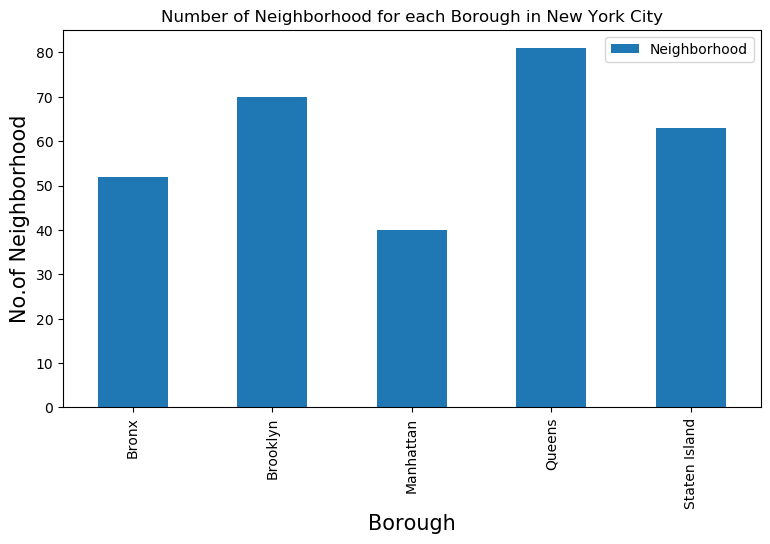

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [10]:
# prepare neighborhood list that contains coffee shops
column_names=['Borough', 'Neighborhood', 'ID','Name']
coffee_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    coffee_shops=venues[venues['Category']=='Coffee Shop']   
    print('(',count,'/',len(new_york_data),')','Coffee Shops in '+Neighborhood+', '+Borough+':'+str(len(coffee_shops)))
    for resturant_detail in coffee_shops.values.tolist():
        id, name , category=resturant_detail
        coffee_rest_ny = coffee_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Coffee Shops in Wakefield, Bronx:0
( 2 / 306 ) Coffee Shops in Co-op City, Bronx:1
( 3 / 306 ) Coffee Shops in Eastchester, Bronx:0
( 4 / 306 ) Coffee Shops in Fieldston, Bronx:1
( 5 / 306 ) Coffee Shops in Riverdale, Bronx:2
( 6 / 306 ) Coffee Shops in Kingsbridge, Bronx:4
( 7 / 306 ) Coffee Shops in Marble Hill, Manhattan:2
( 8 / 306 ) Coffee Shops in Woodlawn, Bronx:0
( 9 / 306 ) Coffee Shops in Norwood, Bronx:1
( 10 / 306 ) Coffee Shops in Williamsbridge, Bronx:0
( 11 / 306 ) Coffee Shops in Baychester, Bronx:1
( 12 / 306 ) Coffee Shops in Pelham Parkway, Bronx:2
( 13 / 306 ) Coffee Shops in City Island, Bronx:0
( 14 / 306 ) Coffee Shops in Bedford Park, Bronx:2
( 15 / 306 ) Coffee Shops in University Heights, Bronx:0
( 16 / 306 ) Coffee Shops in Morris Heights, Bronx:0
( 17 / 306 ) Coffee Shops in Fordham, Bronx:4
( 18 / 306 ) Coffee Shops in East Tremont, Bronx:1
( 19 / 306 ) Coffee Shops in West Farms, Bronx:1
( 20 / 306 ) Coffee Shops in High  Bridge, Bronx:0
( 21 /

In [11]:
coffee_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4eb4295c469073bbc596ef81,Starbucks
1,Bronx,Fieldston,4e7ba557dab43826d2a85f72,Starbucks
2,Bronx,Riverdale,49d73e8ff964a5201f5d1fe3,Starbucks
3,Bronx,Riverdale,4e7ba557dab43826d2a85f72,Starbucks
4,Bronx,Kingsbridge,5660c06b498e4003dba169a5,Mon Amour Coffee & Wine


In [12]:
coffee_rest_ny.shape


(550, 4)

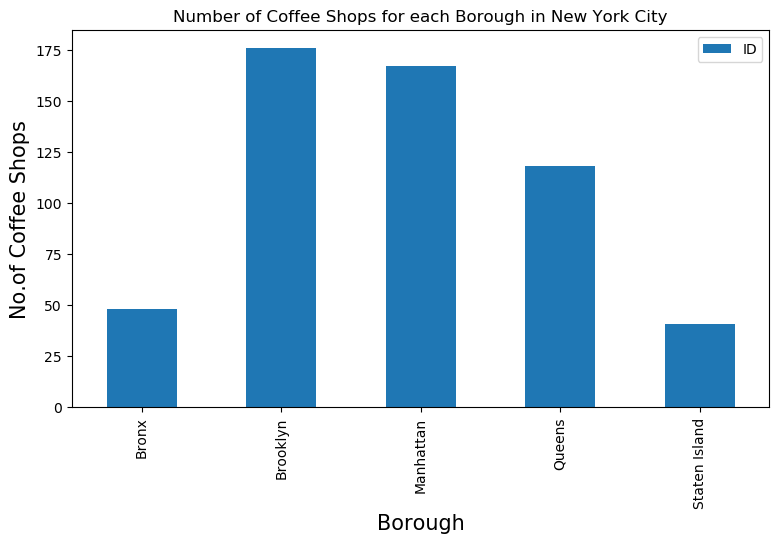

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Coffee Shops for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Coffee Shops', fontsize=15)
#giving a bar plot
coffee_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


## Analysis <a name="Analysis"></a>

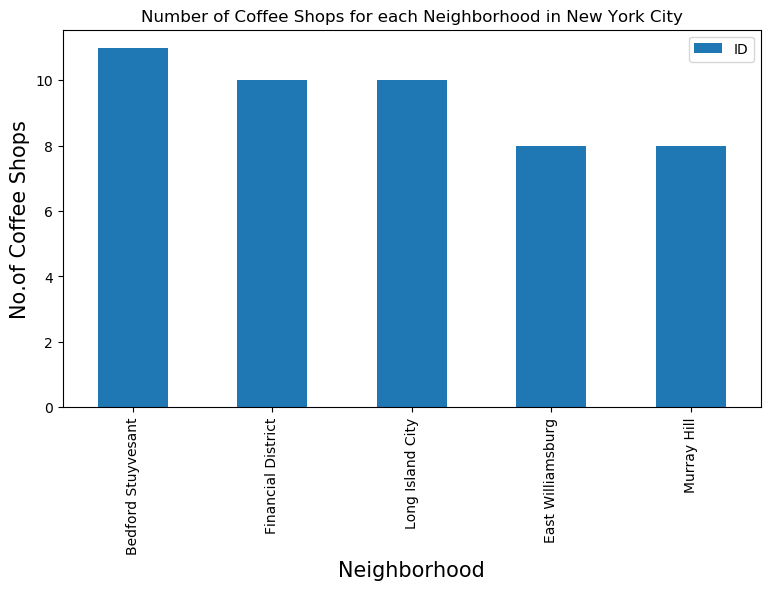

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Coffee Shops for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Coffee Shops', fontsize=15)
#giving a bar plot
coffee_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [15]:
coffee_rest_ny[coffee_rest_ny['Neighborhood']=='Bedford Stuyvesant']


,Borough,Neighborhood,ID,Name
90,Brooklyn,Bedford Stuyvesant,589f51079343e07629090fb6,Little Roy Coffee Co.
91,Brooklyn,Bedford Stuyvesant,56bf7516cd1024b6713b3563,Brooklyn Kettle
92,Brooklyn,Bedford Stuyvesant,56d34672cd10d6b76e3dc455,Nostrand
93,Brooklyn,Bedford Stuyvesant,4d0d29f195c1a1cdfdac00ff,Cinnamon Girl
94,Brooklyn,Bedford Stuyvesant,572e0e7f498ef0f740dd8229,BoHaus Coffee and Flowers
95,Brooklyn,Bedford Stuyvesant,5662f5d3498e53d321cd3456,"S,T Coffee"
96,Brooklyn,Bedford Stuyvesant,55e47f46498e87452e04a281,Willoughby General
97,Brooklyn,Bedford Stuyvesant,54550e00498efbb0dc34de7a,Burly Coffee
98,Brooklyn,Bedford Stuyvesant,5ba95edefe3740002cde5b78,Żabka Coffee
99,Brooklyn,Bedford Stuyvesant,52a102da11d29a428cb564e7,Crocus Coffee


## Results and Conclusions <a name="Results and Conclusions"></a>


In [ ]:
Due to the all the results the best place to put in a Coffee Deposit would be Bedfor Stuyvesant